In [1]:
import torch
from torch.utils.data.sampler import Sampler

from roi_data_layer.roidb import combined_roidb
from roi_data_layer.fss_cell_oneshot_roibatchLoader import roibatchLoader

ModuleNotFoundError: No module named 'roi_data_layer'

In [2]:
class sampler(Sampler):
    def __init__(self, train_size, batch_size):
        self.num_data = train_size
        self.num_per_batch = int(train_size / batch_size)
        self.batch_size = batch_size
        self.range = torch.arange(0,batch_size).view(1, batch_size).long()
        self.leftover_flag = False
        if train_size % batch_size:
            self.leftover = torch.arange(self.num_per_batch*batch_size, train_size).long()
            self.leftover_flag = True

    def __iter__(self):
        rand_num = torch.randperm(self.num_per_batch).view(-1,1) * self.batch_size
        self.rand_num = rand_num.expand(self.num_per_batch, self.batch_size) + self.range

        self.rand_num_view = self.rand_num.view(-1)

        if self.leftover_flag:
            self.rand_num_view = torch.cat((self.rand_num_view, self.leftover),0)

            return iter(self.rand_num_view)

    def __len__(self):
        return self.num_data

In [3]:
imdb_name = 'fss_cell_2020_train'
seen = 1
batch_size = 128
num_workers = 8

In [4]:
# create dataloader
imdb, roidb, ratio_list, ratio_index, query = combined_roidb(imdb_name, True, seen)
train_size = len(roidb)
print('{:d} roidb entries'.format(len(roidb)))

loading annotations into memory...
Done (t=1.43s)
creating index...
index created!
Loaded dataset `fss_cell_2020_train` for training
Set proposal method: gt
fss_cell_2020_train gt roidb loaded from /tmp2/data/cache/fss_cell_2020_train_gt_roidb.pkl
Appending horizontally-flipped training examples...
done
Preparing training data...
done
before filtering, there are 1594 images...
after filtering, there are 1594 images...
1594 roidb entries


In [5]:
imdb._load_coco_annotation(1)

{'width': 696, 'height': 520, 'boxes': array([[ 27,   0,  46,  21],
        [101,   0, 128,  29],
        [126,   0, 147,  20],
        [144,   0, 172,  28],
        [289,   0, 321,  22],
        [352,   0, 369,   7],
        [378,   0, 410,  16],
        [459,   0, 478,   5],
        [622,   0, 645,  10],
        [223,   5, 249,  39],
        [ 64,   7,  97,  45],
        [  0,   8,  26,  28],
        [302,  10, 330,  48],
        [ 19,  26,  62,  57],
        [128,  30, 160,  56],
        [683,  31, 695,  48],
        [158,  33, 188,  59],
        [282,  37, 322,  70],
        [594,  37, 613,  59],
        [523,  38, 561,  78],
        [  0,  39,  18,  59],
        [652,  41, 679,  63],
        [461,  46, 504,  75],
        [604,  49, 623,  67],
        [ 49,  51,  69,  65],
        [207,  52, 233,  77],
        [130,  54, 162,  79],
        [662,  57, 692,  90],
        [ 17,  66,  65, 107],
        [356,  67, 394,  87],
        [624,  70, 657,  98],
        [  0,  73,   6,  94],
  

In [6]:
from roi_data_layer.minibatch import get_minibatch

In [7]:
index_ratio = int(ratio_index[0])
minibatch_db = [roidb[index_ratio]]

In [8]:
blobs = get_minibatch(minibatch_db, imdb.num_classes)

In [9]:
sampler_batch = sampler(train_size, batch_size)
dataset = roibatchLoader(roidb, ratio_list, ratio_index, query, batch_size, imdb.num_classes, training=True)

In [10]:
#dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
#                        sampler=sampler_batch, num_workers=num_workers)

In [11]:
for item in dataset:
    print(len(item), item[0].size())
    break

6 torch.Size([3, 600, 600])


In [12]:
item

(tensor([[[-0.0972, -0.1342, -0.1942,  ..., -0.8609, -0.8192, -0.7822],
          [-0.0972, -0.1253, -0.1885,  ..., -0.8733, -0.8349, -0.8068],
          [ 0.0763,  0.0583,  0.0062,  ..., -0.9006, -0.8685, -0.8438],
          ...,
          [-1.0482, -1.0424, -1.0311,  ...,  1.7988,  1.8085,  1.8208],
          [-1.0247, -1.0158, -1.0006,  ...,  1.8037,  1.8085,  1.8208],
          [-0.9797, -0.9797, -0.9614,  ...,  1.8093,  1.8106,  1.8160]],
 
         [[-1.1078, -1.1457, -1.2070,  ..., -1.3985, -1.3557, -1.3179],
          [-1.1078, -1.1366, -1.1810,  ..., -1.4111, -1.3719, -1.3431],
          [-0.9211, -0.9261, -0.9611,  ..., -1.4390, -1.4062, -1.3810],
          ...,
          [-1.6401, -1.6342, -1.6225,  ...,  1.9378,  1.9549,  1.9734],
          [-1.6632, -1.6541, -1.6386,  ...,  1.9384,  1.9468,  1.9685],
          [-1.6489, -1.6489, -1.6303,  ...,  1.9441,  1.9454,  1.9510]],
 
         [[ 0.0953,  0.0577, -0.0034,  ..., -0.2637, -0.2212, -0.1835],
          [ 0.0702,  0.0416,

In [12]:
import os
name = os.path.join(item[-1].split('/')[4], item[-1].split('/')[5])

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
from PIL import Image, ImageDraw

In [14]:
from torchvision import transforms
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

In [15]:
item = dataset[600]

In [16]:
im = inv_normalize(item[0]).permute(1, 2, 0).data.numpy()
query = inv_normalize(item[1]).permute(1, 2, 0).data.numpy()
im = (im - im.max()) / (im.max() - im.min())
im = (im * 255).astype(np.uint8)
query = (query - query.max()) / (query.max() - query.min())
query = (query * 255).astype(np.uint8)
im = Image.fromarray(im)
query = Image.fromarray(query)

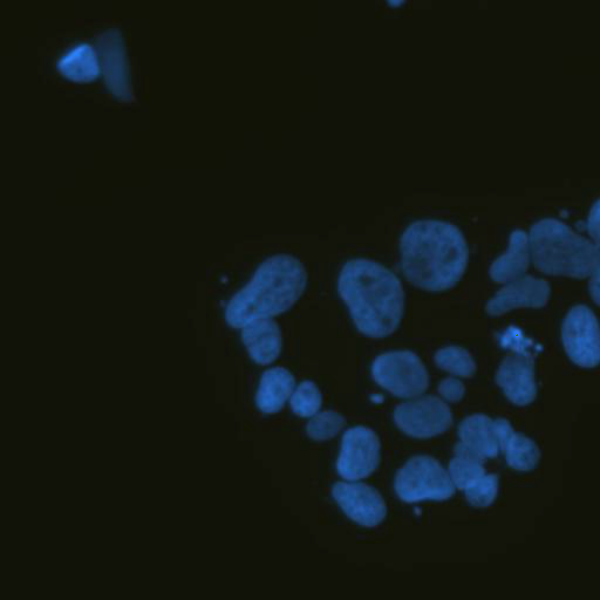

In [17]:
im

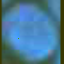

In [18]:
query

In [19]:
img_w, img_h = query.size
background = Image.new('RGB', (im.size), (0, 0, 0))
bg_w, bg_h = background.size
offset = ((bg_w - img_w) // 2, (bg_h - img_h) // 2)
background.paste(query, offset)

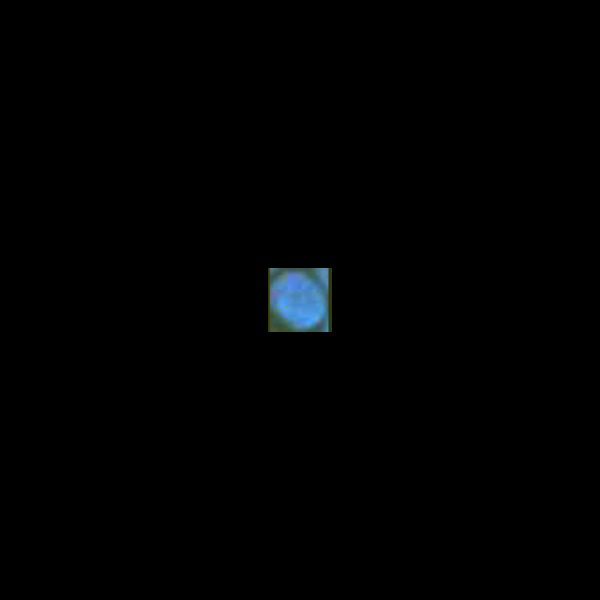

In [20]:
background

In [21]:
cnt = 0
for bbox in item[3]:
    if bbox.float().sum().item()==0:
        break
    bbox = tuple(list(map(int,bbox[0:4].tolist())))
    
    print(bbox)
    draw = ImageDraw.Draw(im)
    draw.rectangle(bbox, fill=None, outline=(255, 0, 110), width = 2)
    cnt += 1
print(cnt)

(457, 412, 499, 459)
(338, 257, 404, 337)
(496, 348, 535, 404)
(486, 275, 550, 315)
(562, 304, 598, 365)
(92, 28, 133, 103)
(372, 349, 430, 398)
(400, 217, 469, 291)
(466, 474, 499, 506)
(394, 453, 458, 502)
(58, 43, 101, 83)
(241, 315, 283, 364)
(255, 365, 298, 413)
(225, 253, 308, 331)
(588, 266, 598, 304)
(332, 481, 387, 526)
(528, 216, 598, 278)
(394, 392, 452, 438)
(438, 377, 466, 401)
(290, 380, 323, 417)
(434, 344, 476, 377)
(448, 453, 487, 492)
(588, 199, 598, 246)
(492, 414, 516, 452)
(336, 424, 382, 481)
(489, 229, 530, 282)
(506, 431, 542, 471)
(305, 408, 348, 441)
28


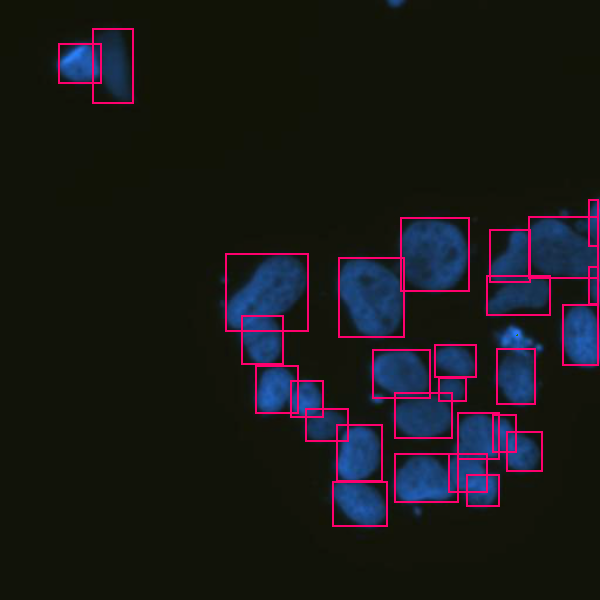

In [22]:
im

In [23]:
from PIL import Image, ImageFont, ImageDraw, ImageOps
im = ImageOps.expand(im, border=(0,15,0,0), fill=(0,0,0))
draw = ImageDraw.Draw(im)
font = ImageFont.truetype("usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf", 12)
draw.text((0,0), name, (255,255,255), font=font)

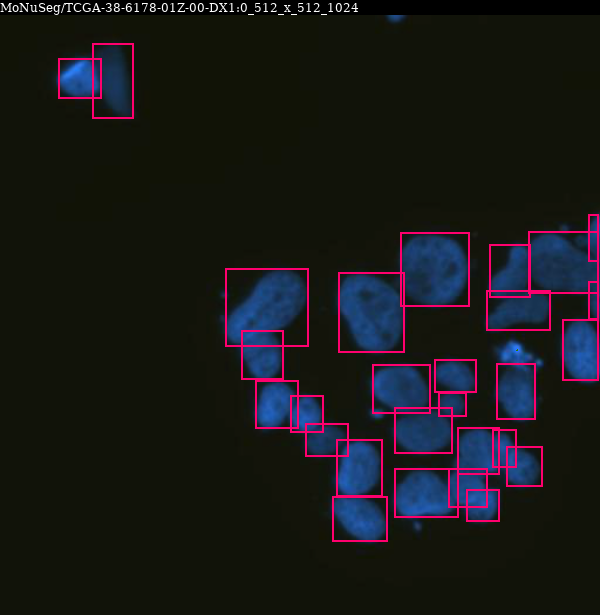

In [24]:
im